  0%|          | 0/1000 [00:00<?, ?it/s, loss=5.398555]

Epoch 0, loss 5.398554801940918


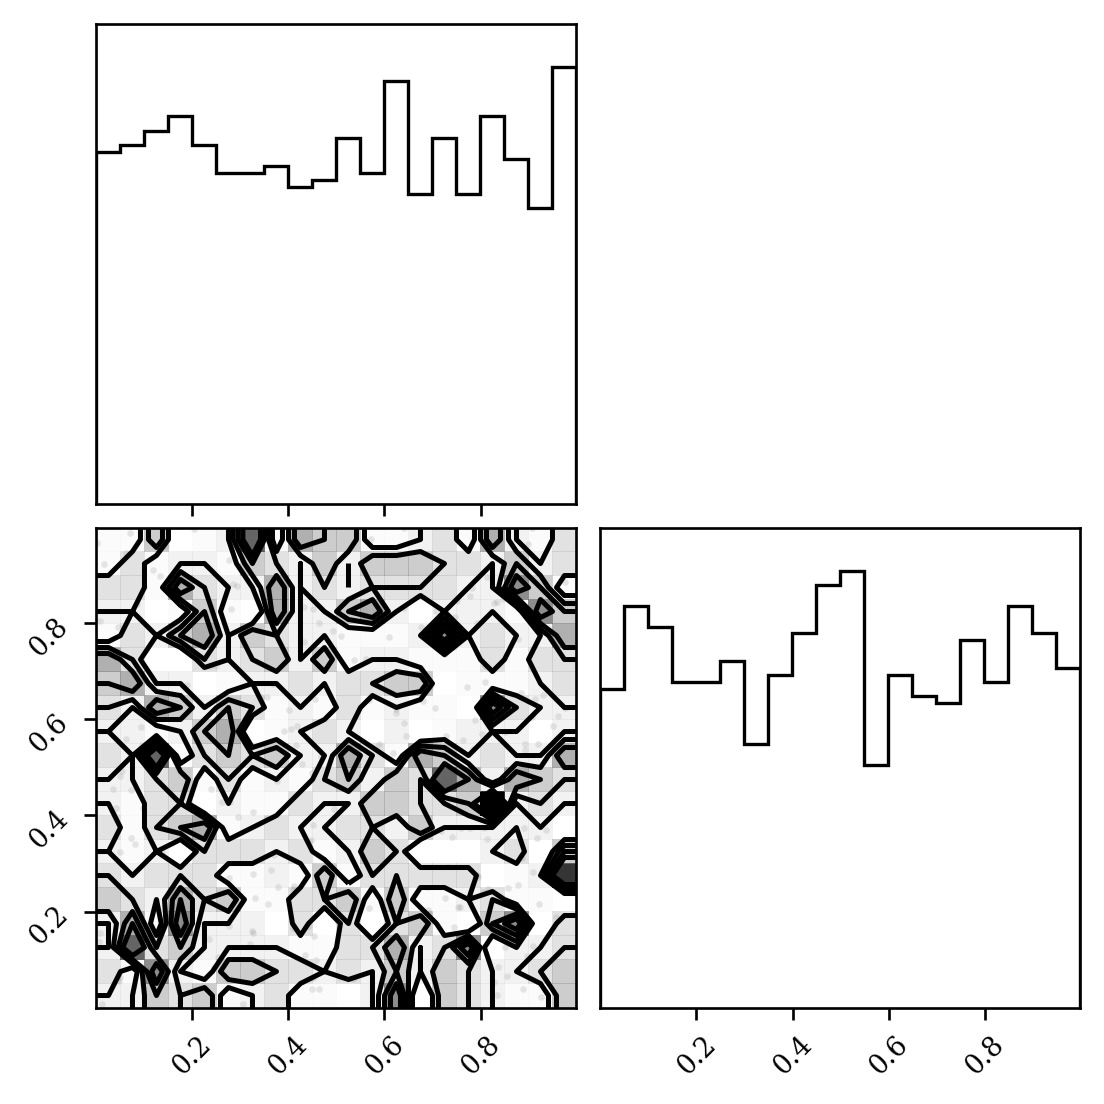

 10%|█         | 100/1000 [01:33<12:39,  1.18it/s, loss=-0.66742754]

Epoch 100, loss -0.6674275398254395


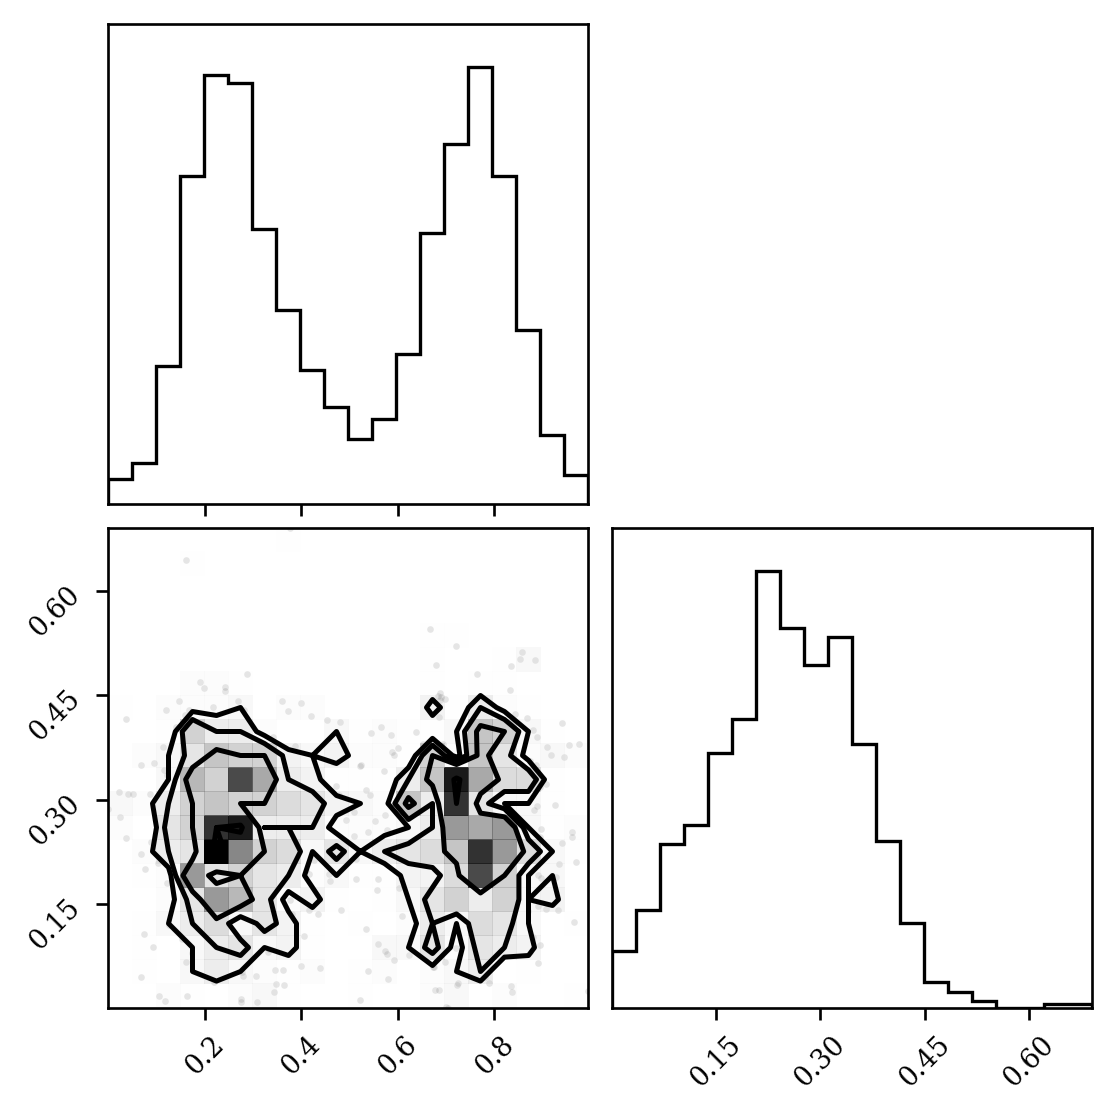

 20%|██        | 200/1000 [03:00<11:45,  1.13it/s, loss=-0.6739971] 

Epoch 200, loss -0.6739971041679382


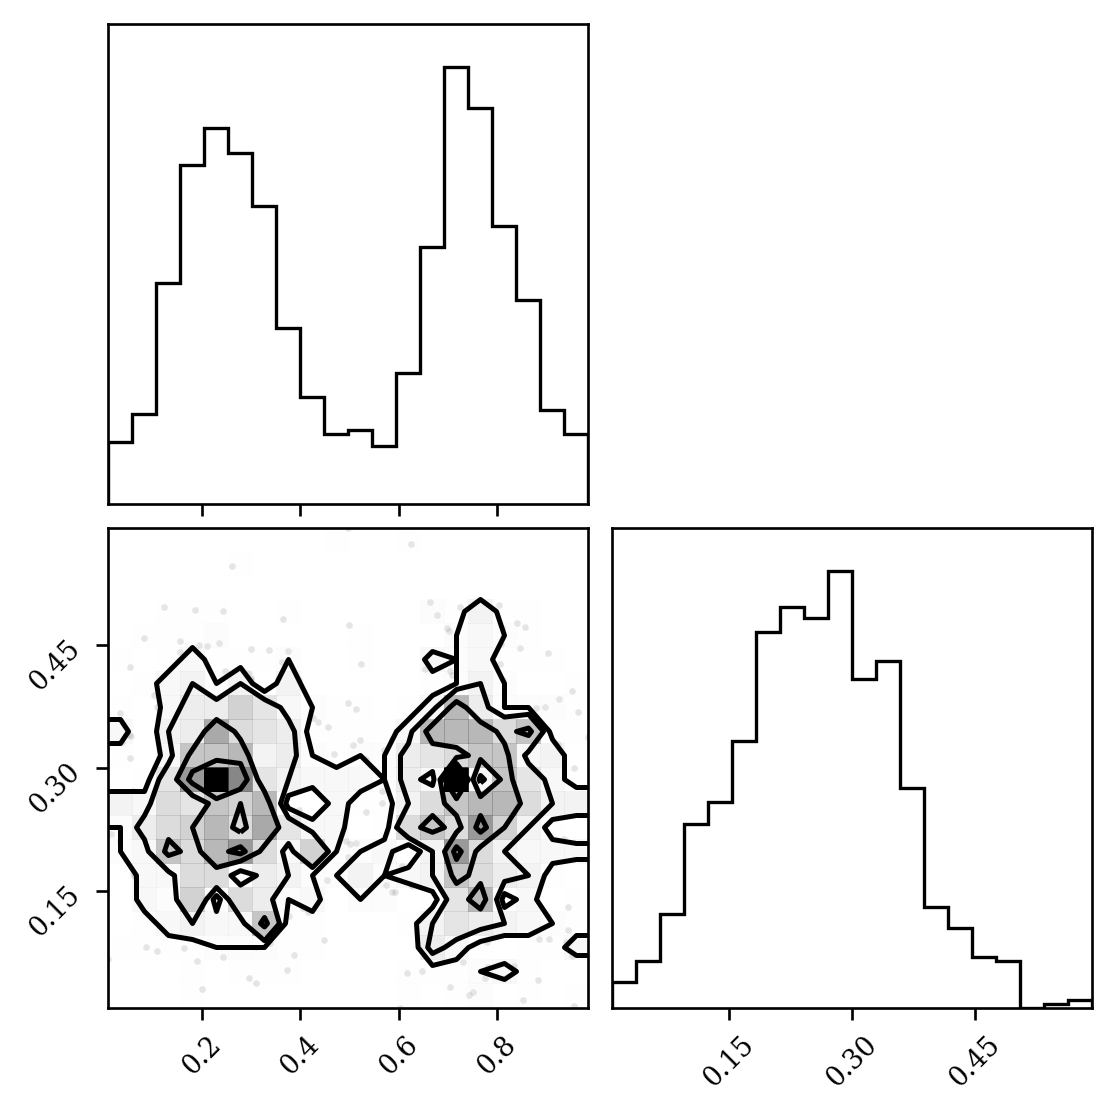

 30%|███       | 300/1000 [04:31<10:22,  1.12it/s, loss=-0.67541766]

Epoch 300, loss -0.6754176616668701


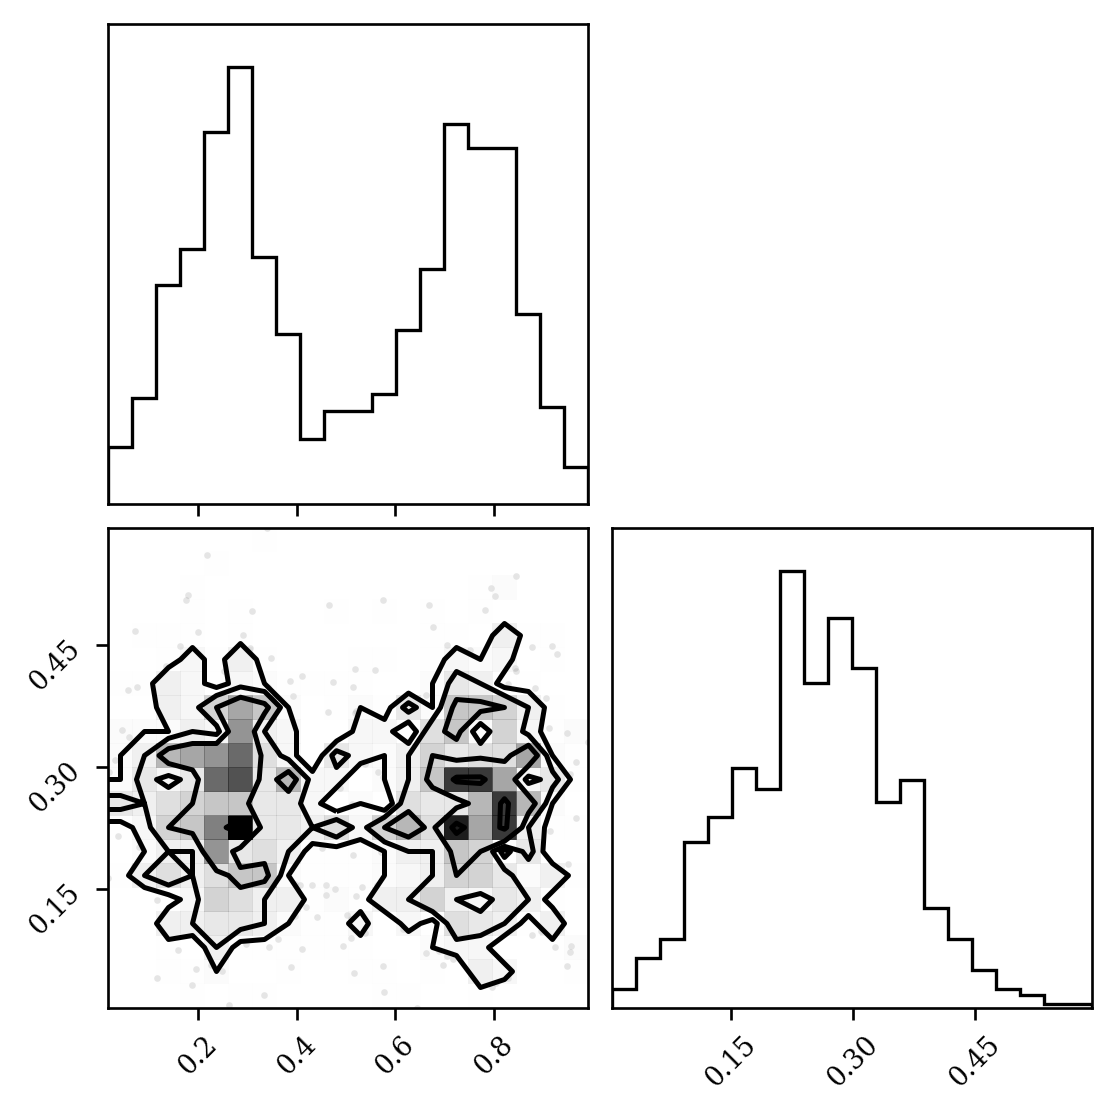

 40%|████      | 400/1000 [06:01<08:50,  1.13it/s, loss=-0.679022]  

Epoch 400, loss -0.6790220141410828


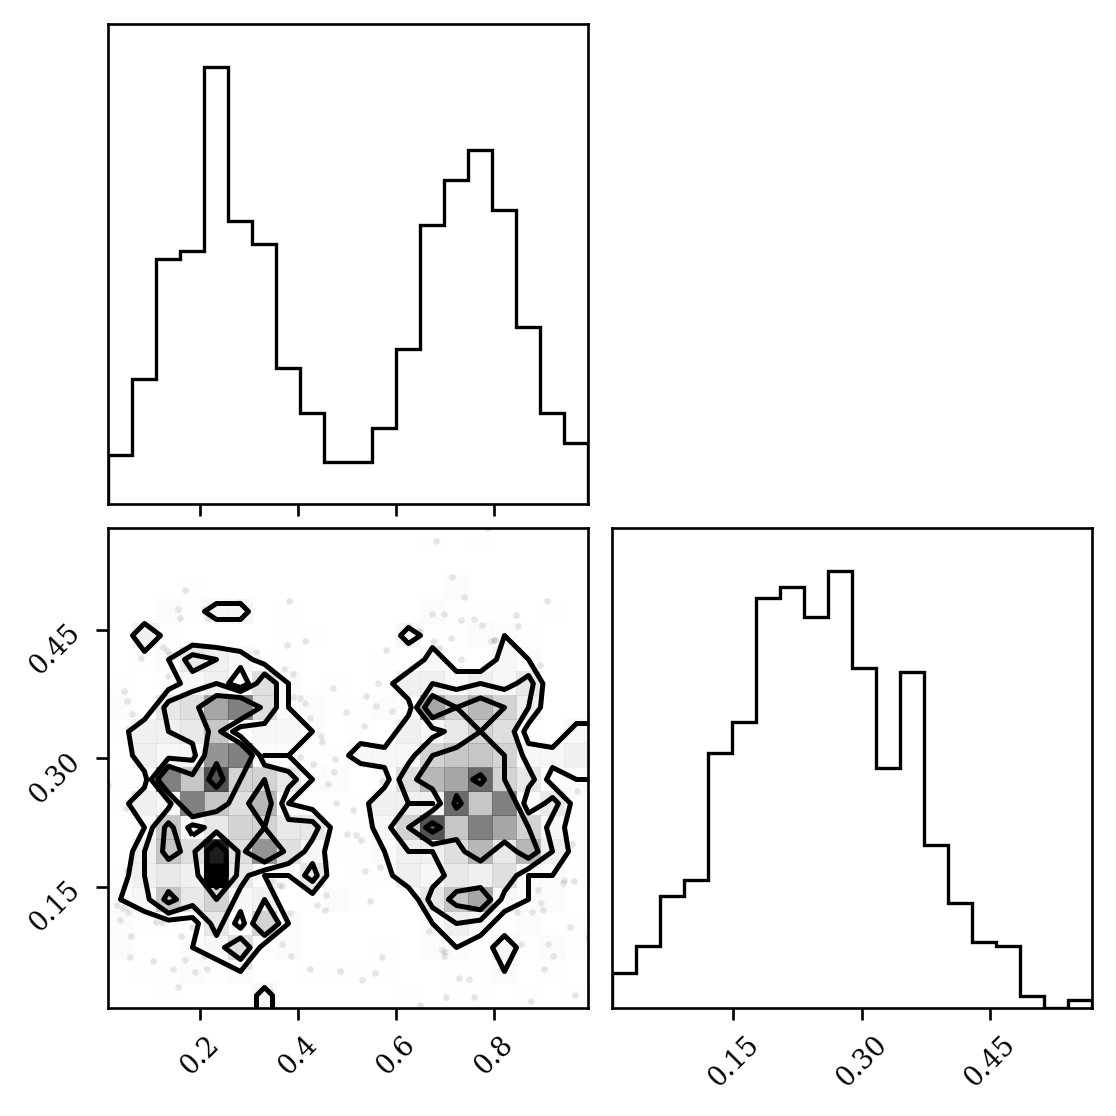

 50%|█████     | 500/1000 [07:33<07:45,  1.07it/s, loss=-0.679111]  

Epoch 500, loss -0.6791110038757324


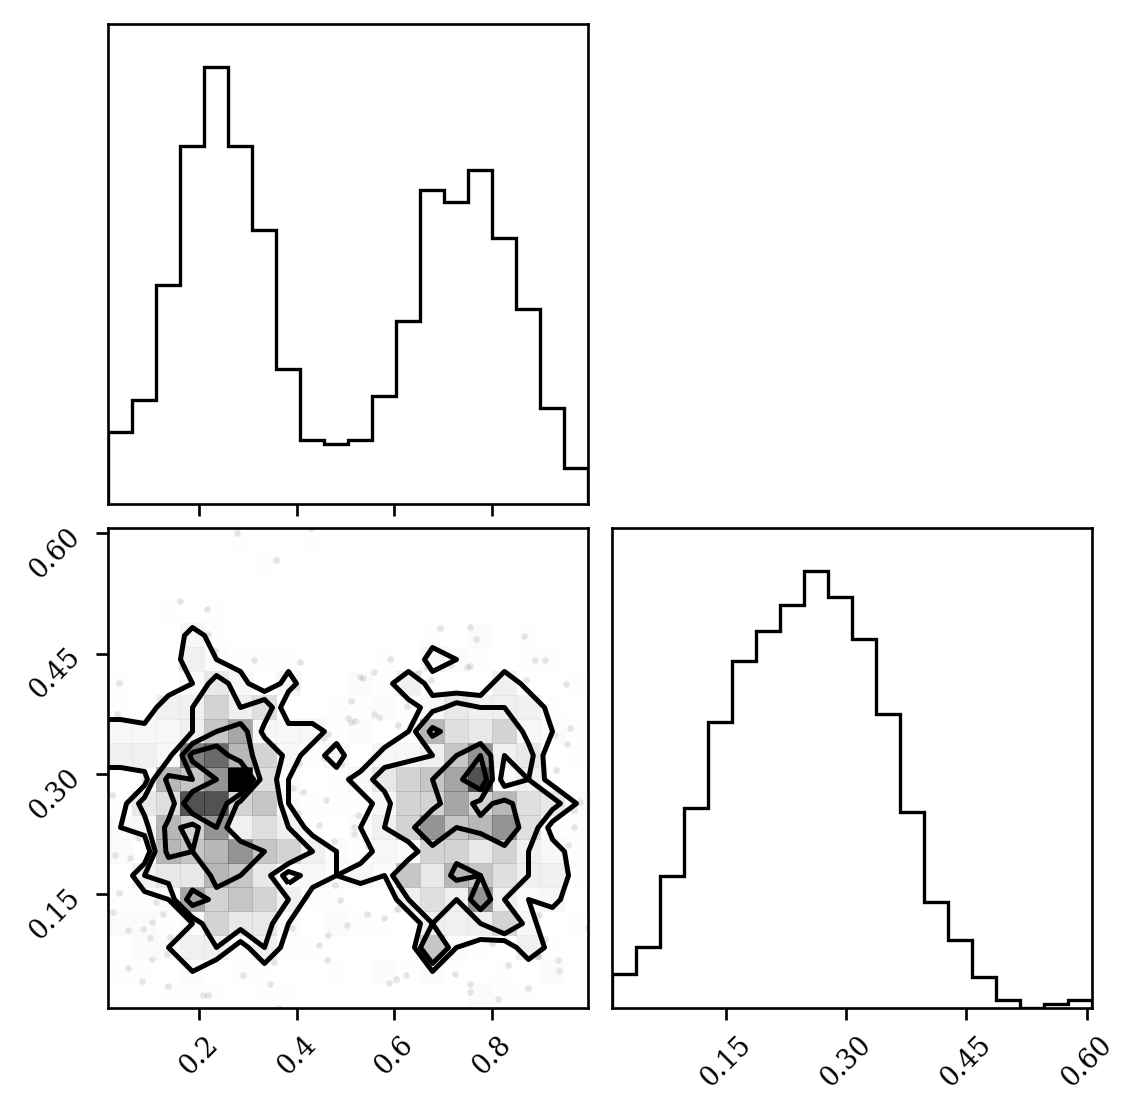

 60%|██████    | 600/1000 [09:05<06:12,  1.07it/s, loss=-0.6794964] 

Epoch 600, loss -0.6794964075088501


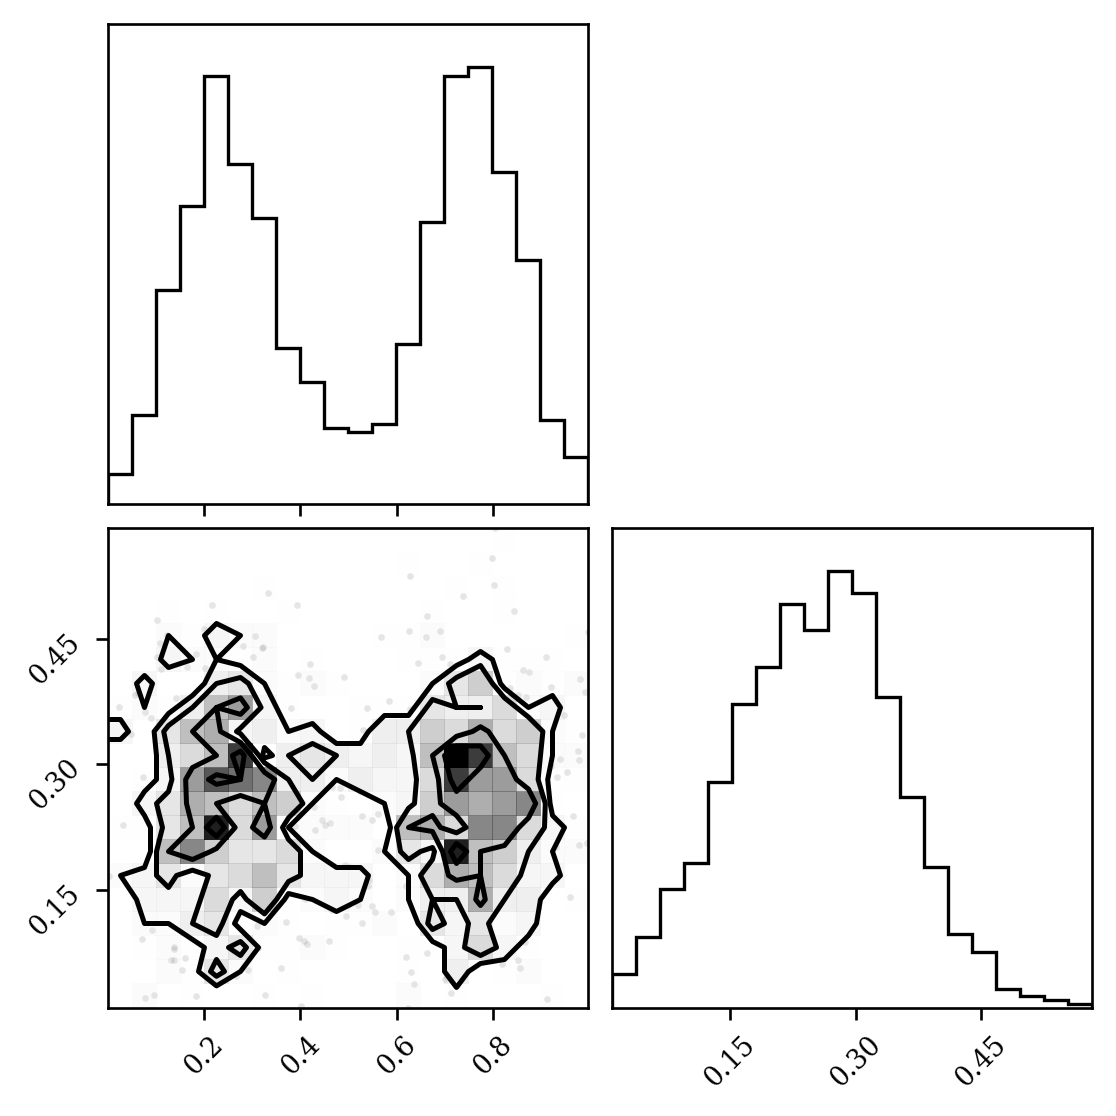

 70%|███████   | 700/1000 [10:38<04:38,  1.08it/s, loss=-0.6755651] 

Epoch 700, loss -0.6755651235580444


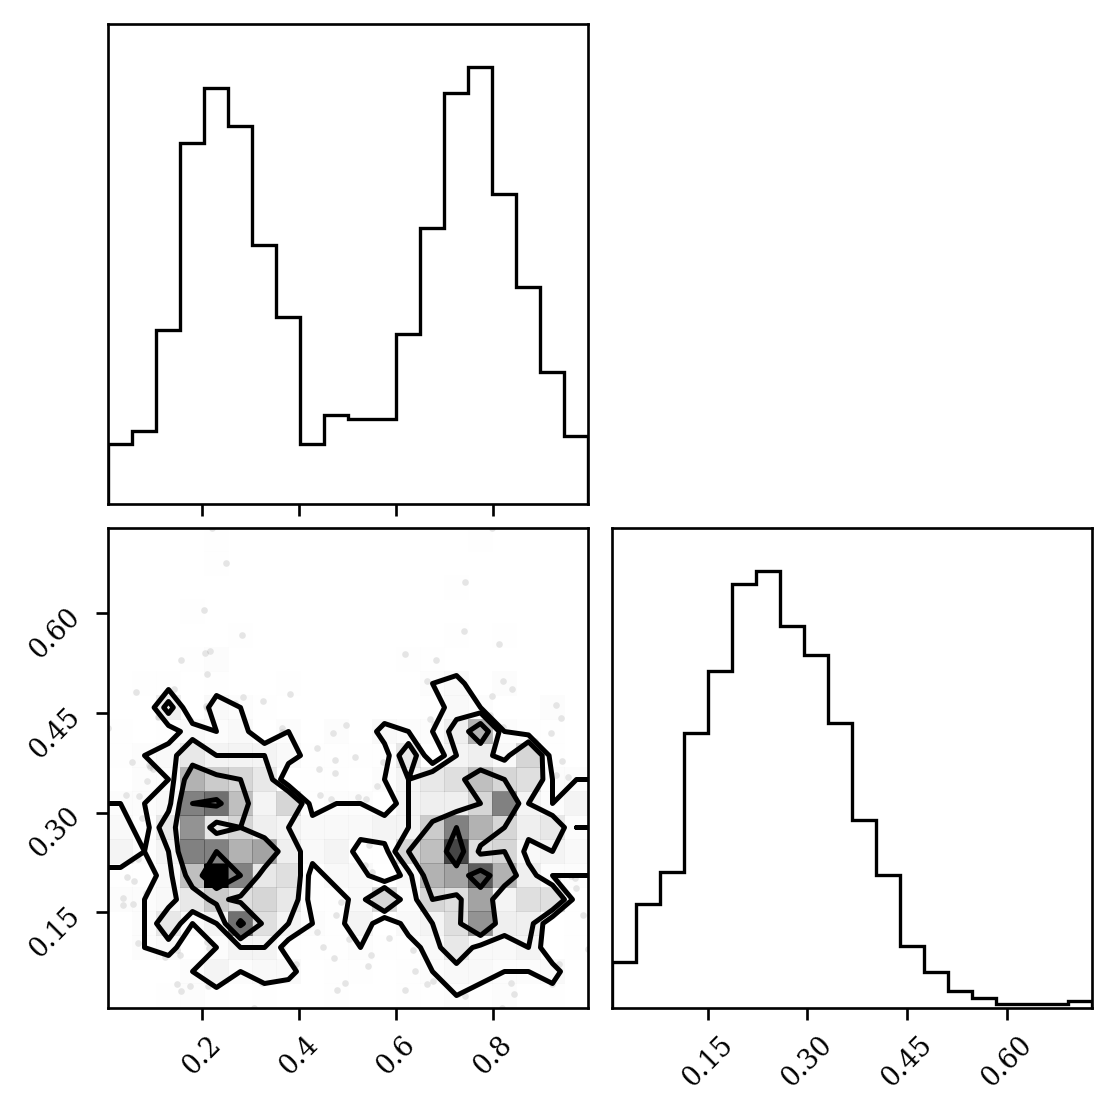

 80%|████████  | 800/1000 [12:11<03:18,  1.01it/s, loss=-0.6750955] 

Epoch 800, loss -0.6750954985618591


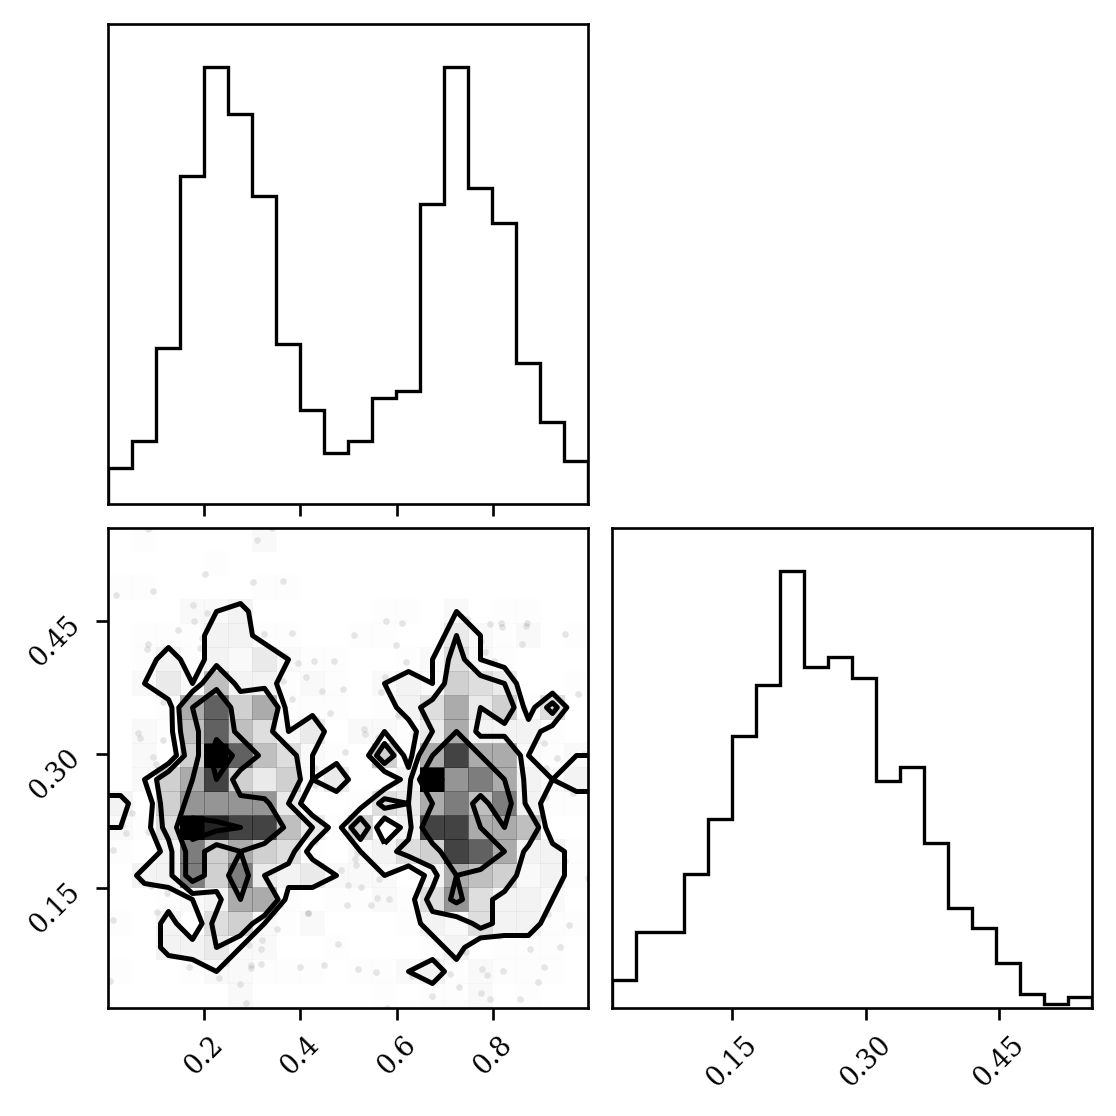

 90%|█████████ | 900/1000 [13:43<01:35,  1.05it/s, loss=-0.6681261] 

Epoch 900, loss -0.668126106262207


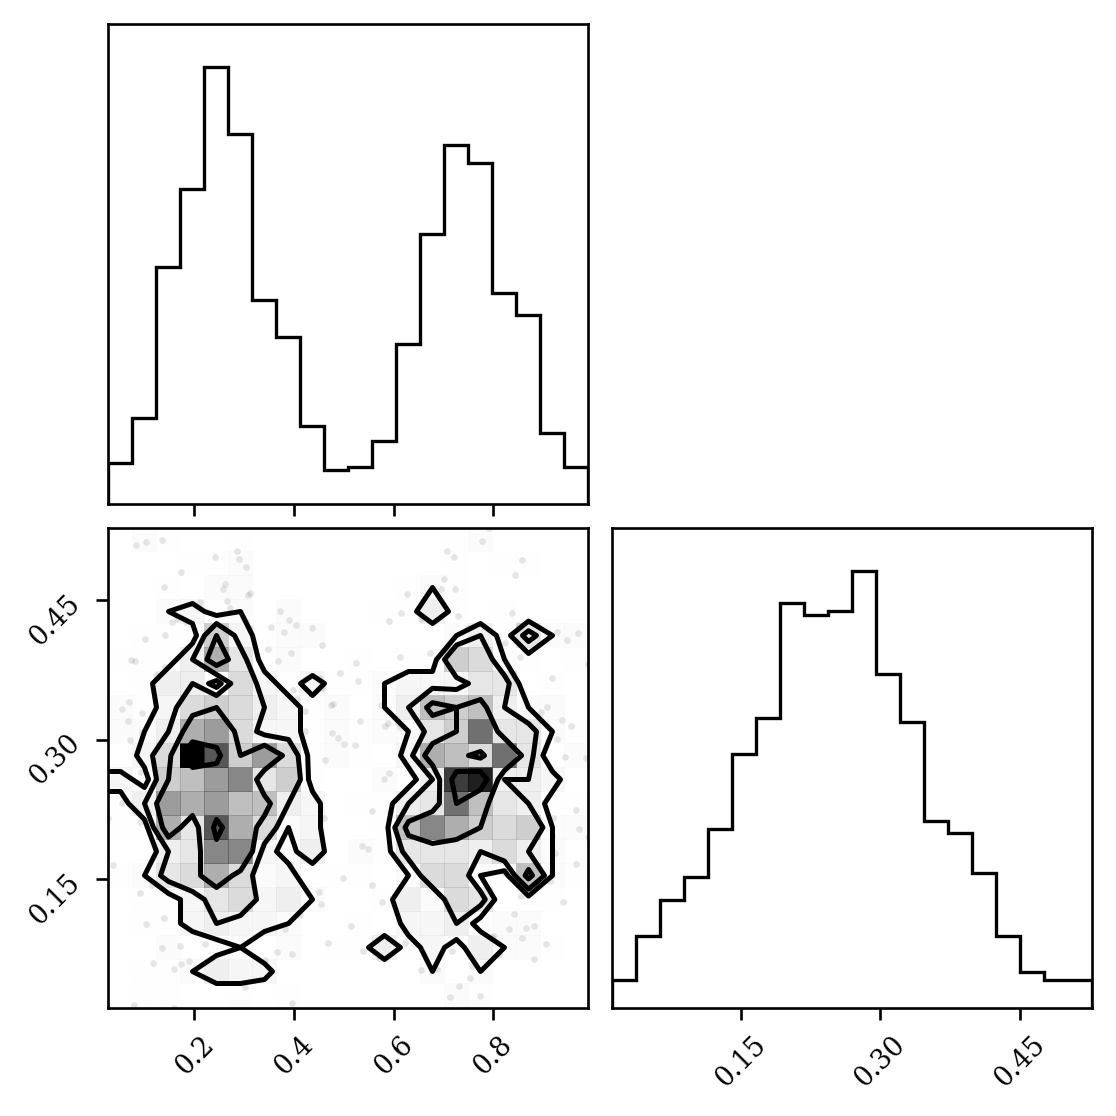

100%|██████████| 1000/1000 [15:17<00:00,  1.09it/s, loss=-0.67467207]


Done!


NameError: name 'run_name' is not defined

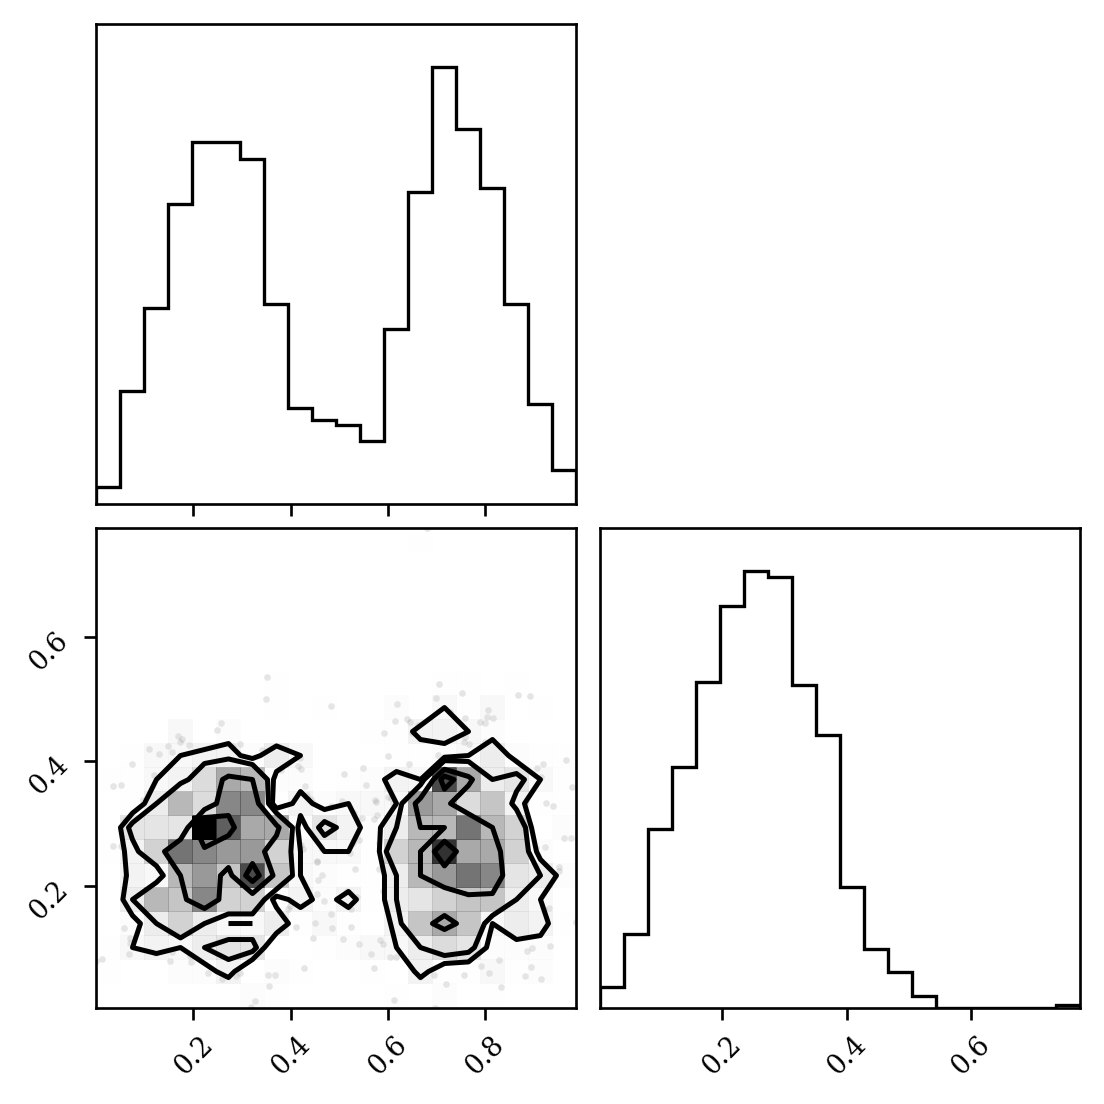

In [ ]:
#import wandb
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as pl
import sys
import csv
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import haiku as hk
import optax
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any
jax.config.update('jax_platform_name', 'cpu')
JAX_DISABLE_JIT=1


# Define a target distribution (2D bimodial gaussian)
def log_target(x):   
    mean_1 = jnp.array([0.25,0.25])
    cov_1 = jnp.array([[0.01,0],[0,0.01]])
    mean_2 = jnp.array([0.75,0.25])
    cov_2 =jnp.array([[0.01,0],[0,0.01]])
    return jnp.log(jax.scipy.stats.multivariate_normal.pdf(x, mean_1, cov_1)+ jax.scipy.stats.multivariate_normal.pdf(x, mean_2, cov_2))

#def log_target(x):
#    x = x.T
#    return  (2 + jnp.cos(x[0]*10*np.pi/2)*jnp.cos(x[1]*10*np.pi/2))**5 

#from vi_routines import make_flow_model
from vi_routines import make_flow_model

# Training routines:

#flow model
@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:      # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of the sampled points)

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        bernstein_degree=bernstein_degree
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))

#target
def log_prob(x: Array) -> Array:
    return log_target(x)

#Loss - reverse KL between the flow and the target
def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.
    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_prob(x_flow)      #gets log of target prob for the sampled points                                 
    loss = jnp.mean(log_q - log_p)    #reverse KL
    return loss

#Gradient descent
#@jax.jit
def update(                        #training update with stochastic gradient descent.
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps) #gradient w.r.t. params, evalueated at params, prng_key, Nsamps.
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


#Training log routines:
def kl_ess(log_model_prob, log_target_prob):  #computes an evidence estimate, KL & effective sample size for logging. 
    weights = jnp.exp(log_target_prob - log_model_prob)   # sample weights, w = p/q
    Z = jnp.mean(weights)  # evidence estimate
    KL = jnp.mean(log_model_prob - log_target_prob) + jnp.log(Z)  # KL estimate taking into account evidence
    ESS = jnp.sum(weights) ** 2 / jnp.sum(weights ** 2)      # effective sample size estimate
    return Z, KL, ESS

def init_logging(filename):
    logf = open(filename, 'a')
    fieldnames = ['iter', 'loss', 'kl', 'ess']
    writer = csv.DictWriter(logf, fieldnames=fieldnames)
    if os.stat(filename).st_size == 0:
        writer.writeheader()
        logf.flush()
    return logf, writer

#Training Loop

if __name__ == '__main__':

    #run_name = 'test_BP' #name of the run
    #os.mkdir('results/test_splines')

    #flow parameters
    n_params = 2       #dimensionality of the domain
    flow_num_layers = 4   
    hidden_size = 128
    mlp_num_layers = 2
    bernstein_degree = 20

    #training parameters
    epochs = 1000
    Nsamps = 1000

    learning_rate = 0.0001
    optimiser = optax.adam(learning_rate)             #single optimiser.. #single network..


    #initialise the flow
    prng_seq = hk.PRNGSequence(42)
    key = next(prng_seq)
    params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
    opt_state = optimiser.init(params)

    from tqdm import tqdm, trange
    import corner

    ldict = dict(loss = [])
    lossdict = dict(loss = [])

    #start logging:
    #logf, writer = init_logging(f'results/{run_name}/log.csv')

    #Training loop:
    with trange(epochs) as tepochs:
            for epoch in tepochs:
                prng_key = next(prng_seq)
                loss = loss_fn(params,  prng_key, Nsamps)
                ldict['loss'] = loss
                lossdict['loss'].append(loss)
                tepochs.set_postfix(ldict, refresh=True)
                params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)

                #every n epochs write training stats to a file and plot the current flow distribution
                if (epoch)%100 == 0:
                    print(f'Epoch {epoch}, loss {loss}')

                    x_gen, log_flow = sample_and_log_prob.apply(params, next(prng_seq), Nsamps)
                    log_p = log_prob(x_gen)
                    
                    #_, kl, ess = kl_ess(log_flow, log_p)
                    #ess = ess / Nsamps * 100  #percentage effective samples size 
                    #writer.writerow({'iter': epoch, 'loss': loss, 'kl': kl, 'ess': ess})
                    #logf.flush()

                    fig = corner.corner(np.array(x_gen, copy=False))
                    pl.show()
                    pl.close()
                

                
    print("Done!")  

    #Save results:

    x_gen, log_flow = sample_and_log_prob.apply(params, next(prng_seq), Nsamps)

    fig = corner.corner(np.array(x_gen, copy=False))
    pl.savefig(f'results/{run_name}/posterior_flow.png')
    pl.close()

    L=np.array(lossdict['loss'])
    pl.plot(L)
    pl.xlabel("Iteration")
    pl.ylabel("Loss")
    pl.savefig(f'results/{run_name}/loss.png')
    pl.close()

    f = open(f'results/{run_name}/loss.npy', 'wb')
    np.save(f,L)
    f.close()